In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from sklearn import decomposition
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('data/embed-non-negative.csv', low_memory=False)
# df = pd.read_csv("/vol/biomedic3/mb121/tech-demo/code_for_demo/joined_simple.csv", low_memory=False)
df['image_id'] = [img_path.split('/')[-1] for img_path in df.image_path.values]
print(df.shape)

(398458, 57)


In [3]:
real_path = 'final_models_2/real_only_resnet50_bs64_lr0.0001_epochs10'
cf_and_real_path = 'final_models_2/cf_and_real_resnet50_bs256_lr0.0005_epochs10'

In [ ]:
def get_combined_embeddings_predictions_df(path):
    df_prd = pd.read_csv(os.path.join(path, 'predictions.csv'))
    df_emb = pd.read_csv(os.path.join(path, 'embeddings.csv'))
    
    df_combined = df_emb.merge(df_prd, on='image_id')
    df_combined['base_image_id'] = df_combined['image_id'].apply(lambda x: x.split('/')[0])

    df = df_combined.merge(df, left_on='base_image_id', right_on='image_id')
    
    df['prediction'] = df[['class_0', 'class_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
    df['density_binary'] = df['density'].apply(lambda x: 0 if x in ['A', 'B'] else 1)
    df['correct'] = (df['prediction'] == df['density_binary']).astype(int)
    
    df.head()
    
def get_embeddings(df, num_features=512):
    embeddings = np.array(df.iloc[:,0:num_features])
    print(embeddings.shape)
    
def get_pca_embeddings(embeddings):
    pca = decomposition.PCA(n_components=0.95, whiten=False)
    embeddings_pca = pca.fit_transform(embeddings)
    print(embeddings_pca.shape)
    
def get_pca(path):
    df = get_combined_embeddings_predictions_df(path)
    

(2901, 512)


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


density_binary
0    1612
1    1289
Name: count, dtype: int64

density_binary
0    0.55567
1    0.44433
Name: proportion, dtype: float64


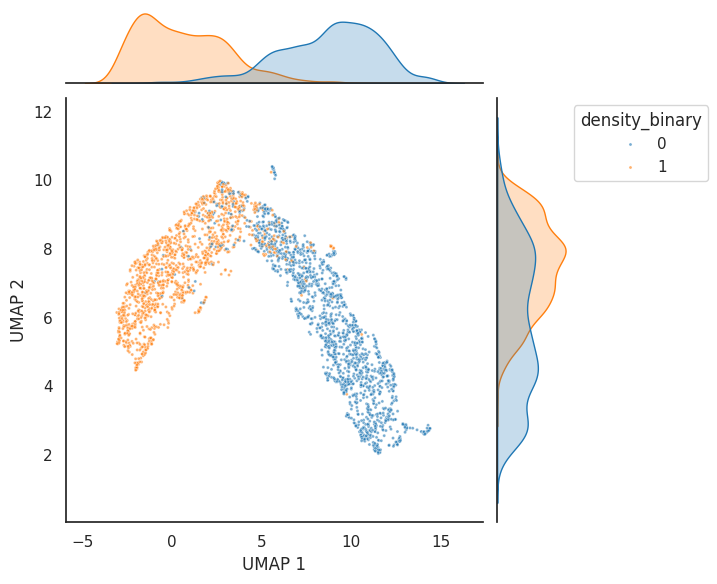

In [102]:
import umap

# Replace TSNE with UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_model.fit_transform(embeddings_pca)

# Add to DataFrame
df['UMAP 1'] = embeddings_umap[:, 0]
df['UMAP 2'] = embeddings_umap[:, 1]

# Use same scatter/joint plot with UMAP dimensions
x = 'UMAP 1'
y = 'UMAP 2'

def plot_scatter(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

def plot_joint(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.jointplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette, marginal_kws={'common_norm': False})
    sns.move_legend(ax.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))
    
attributes = ['Manufacturer', 'ManufacturerModelName', 'FinalImageType', 'ViewPosition', 
              'ImageLateralityFinal', 'race', 'is_positive', 'density', 'class_0', 'class_1', 'correct']

def plot_attribute(attribute):
    print(df[attribute].value_counts(normalize=False))
    print('')
    print(df[attribute].value_counts(normalize=True))

    plot_joint(df, attribute, x, y, color_palette)
    
plot_attribute('density_binary')

In [109]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assume you already have this:
# - embeddings_2d: your 2D UMAP or t-SNE output
# - labels: true class labels (0 or 1)

sil_score = silhouette_score(embeddings_umap, df['density_binary'])
db_score = davies_bouldin_score(embeddings_umap, df['density_binary'])

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")

Silhouette Score: 0.520
Davies-Bouldin Index: 0.649


In [72]:
df['PCA 1'] = embeddings_pca[:,0]
df['PCA 2'] = embeddings_pca[:,1]

In [56]:
tsne = TSNE(n_components=2, init='random', learning_rate='auto')
embeddings_tsne = tsne.fit_transform(embeddings_pca)

print(embeddings_tsne.shape)

(2901, 2)


In [57]:
df['t-SNE 1'] = embeddings_tsne[:,0]
df['t-SNE 2'] = embeddings_tsne[:,1]

In [58]:
df = df.sample(frac=1.0)

In [59]:
alpha = 0.6
style = '.'
markersize = 20
color_palette = 'tab10'
kind = 'scatter'

In [60]:
# x = 'PCA 1'
# y = 'PCA 2'
x = 't-SNE 1'
y = 't-SNE 2'

In [61]:
def plot_scatter(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

def plot_joint(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.jointplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette, marginal_kws={'common_norm': False})
    sns.move_legend(ax.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))
    
attributes = ['Manufacturer', 'ManufacturerModelName', 'FinalImageType', 'ViewPosition', 
              'ImageLateralityFinal', 'race', 'is_positive', 'density', 'class_0', 'class_1', 'correct']

def plot_attribute(attribute):
    print(df[attribute].value_counts(normalize=False))
    print('')
    print(df[attribute].value_counts(normalize=True))

    plot_joint(df, attribute, x, y, color_palette)

density_binary
0    1612
1    1289
Name: count, dtype: int64

density_binary
0    0.55567
1    0.44433
Name: proportion, dtype: float64


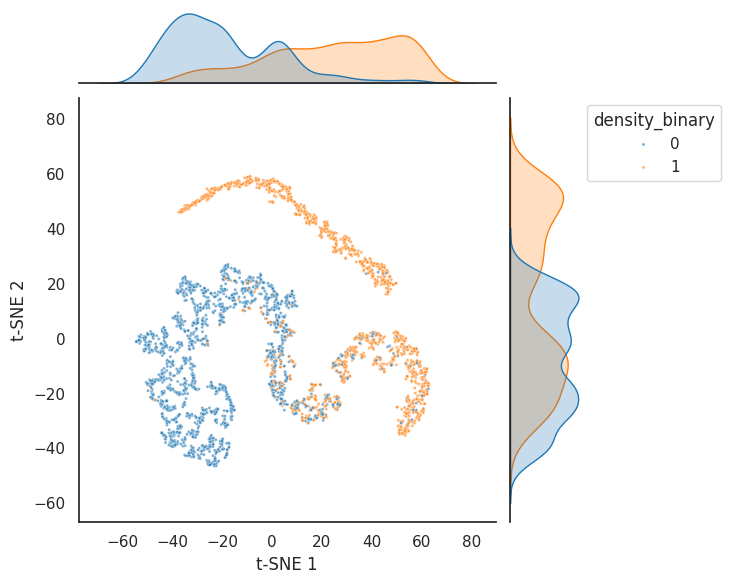

In [63]:
plot_attribute('density_binary')

density
B    1262
C    1150
A     350
D     139
Name: count, dtype: int64

density
B    0.435022
C    0.396415
A    0.120648
D    0.047915
Name: proportion, dtype: float64


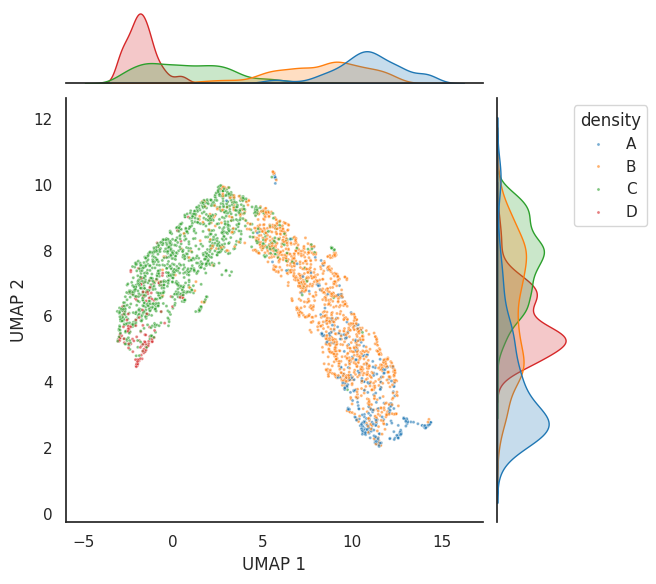

In [103]:
plot_attribute('density')

race
Black            1354
White            1278
Other/Unknown     176
Asian              93
Name: count, dtype: int64

race
Black            0.466736
White            0.440538
Other/Unknown    0.060669
Asian            0.032058
Name: proportion, dtype: float64


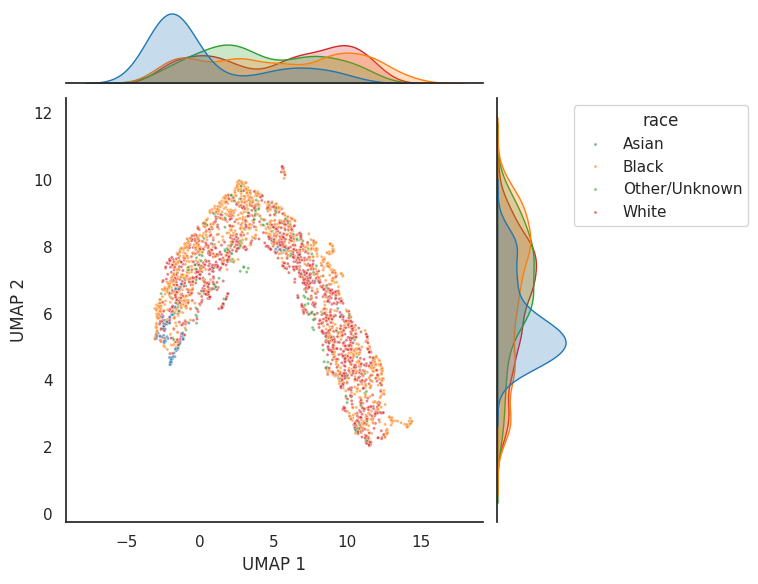

In [104]:
plot_attribute('race')

correct
1    2693
0     208
Name: count, dtype: int64

correct
1    0.928301
0    0.071699
Name: proportion, dtype: float64


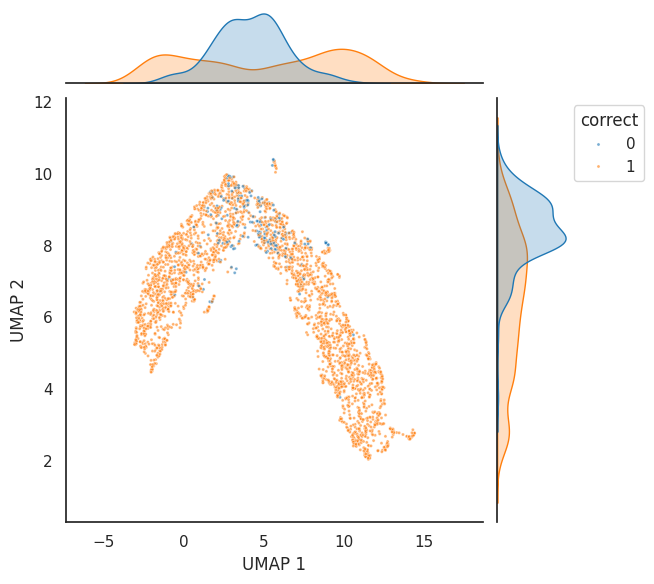

In [105]:
plot_attribute('correct')

               accuracy
race                   
Asian          0.989247
Black          0.931315
Other/Unknown  0.840909
White          0.932707


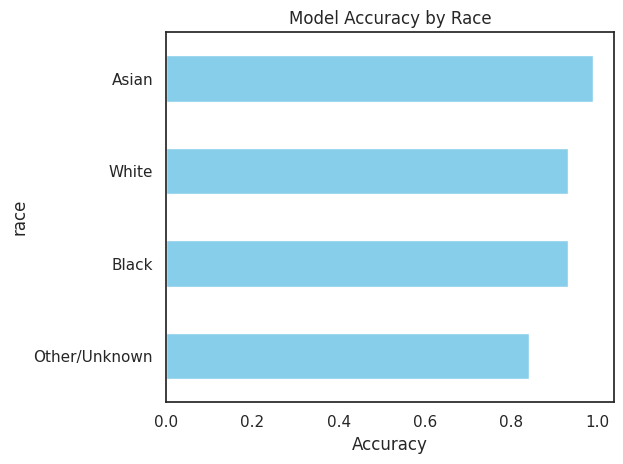

In [106]:
import matplotlib.pyplot as plt

# accuracy by race
accuracy_by_race = df.groupby('race')['correct'].value_counts(normalize=True).unstack().fillna(0)
accuracy_by_race.columns = ['incorrect', 'correct']
accuracy_by_race['accuracy'] = accuracy_by_race['correct']
print(accuracy_by_race[['accuracy']])

accuracy_by_race['accuracy'].sort_values().plot(
    kind='barh',
    title='Model Accuracy by Race',
    xlabel='Accuracy',
    color='skyblue'
)
plt.tight_layout()
plt.show()

         accuracy
density          
A        0.997143
B        0.913629
C        0.914783
D        1.000000


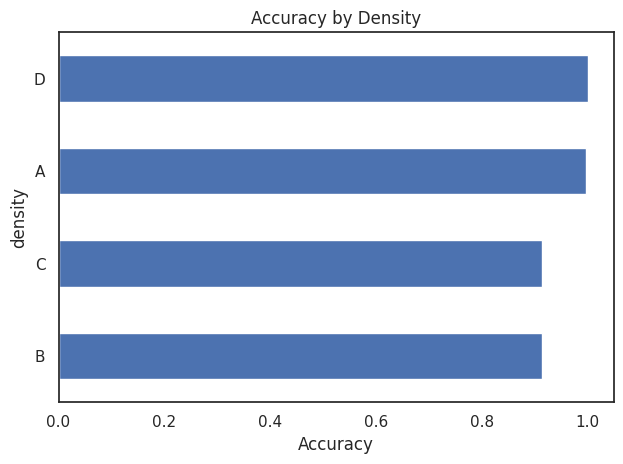

In [107]:
accuracy_by_density = df.groupby('density')['correct'].value_counts(normalize=True).unstack().fillna(0)
accuracy_by_density.columns = ['incorrect', 'correct']
accuracy_by_density['accuracy'] = accuracy_by_density['correct']
print(accuracy_by_density[['accuracy']])

accuracy_by_density['accuracy'].sort_values().plot(kind='barh', title='Accuracy by Density', xlabel='Accuracy')
plt.tight_layout()
plt.show()

In [94]:
# Sort by class_0 ascending and display the lowest values
lowest_class0 = df.sort_values(by='class_0', ascending=True)
print(lowest_class0[['class_0', 'class_1', 'density', 'prediction', 'correct']].head(10))


      class_0   class_1 density  prediction  correct
3    0.895888  0.104112       B           0        1
33   0.897381  0.102619       C           0        0
0    0.901097  0.098903       D           0        0
17   0.901748  0.098252       C           0        0
150  0.908618  0.091382       C           0        0
138  0.909184  0.090816       C           0        0
78   0.910545  0.089455       D           0        0
29   0.911101  0.088899       A           0        1
97   0.911101  0.088899       C           0        0
58   0.911180  0.088820       C           0        0


## Interactive model inspection

In [ ]:
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.transform import resize
from matplotlib import cm
from ipywidgets import Output, HBox

data_dir = '/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/data/'
# data_dir = '/data2/EMBED/1024x768'

In [ ]:
df['density_label'] = 0
df.loc[df['density'] == 'A', 'density_label'] = 0
df.loc[df['density'] == 'B', 'density_label'] = 1
df.loc[df['density'] == 'C', 'density_label'] = 2
df.loc[df['density'] == 'D', 'density_label'] = 3

In [ ]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

color = cm.tab10(np.linspace(0, 1, 10))
colorlist = [(np.array(mpl.colors.to_rgb(c))*255).astype(int).tolist() for c in color]*10

colors = [rgb_to_hex(colorlist[c]) for c in df.is_positive.values]

In [ ]:
def preprocess(image, horizontal_flip=False):

    # breast mask
    image_norm = image - np.min(image)
    image_norm = image_norm / np.max(image_norm)
    thresh = cv2.threshold(img_as_ubyte(image_norm), 5, 255, cv2.THRESH_BINARY)[1]

    # Connected components with stats.
    nb_components, output, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=4)

    # Find the largest non background component.
    # Note: range() starts from 1 since 0 is the background label.
    max_label, _ = max(
        [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)],
        key=lambda x: x[1],
    )
    mask = output == max_label
    image_masked = image.copy()
    image_masked[mask == 0] = 0

    if horizontal_flip:
        image_masked = image_masked[:, ::-1].copy()
        
    return image_masked

In [ ]:
out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    sample = df.iloc[points.point_inds[0]]
    img_orig = imread(os.path.join(data_dir, sample.image_path))
    img_proc = preprocess(img_orig)
    
    s = [8] * len(df)
    for i in points.point_inds:
        s[i] = 16
    with fig.batch_update():
        scatter.marker.size = s

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.imshow(img_orig, cmap='gray')
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(img_proc, cmap='gray')
    ax2.set_title('processed')
    ax2.axis('off')
    plt.show(f)
    
fig = go.FigureWidget(px.scatter(df, x=x, y=y, template='simple_white', hover_data={'ManufacturerModelName': True, x:False, y:False}))
fig.update_layout(width=600, height=600)
scatter = fig.data[0]
scatter.on_click(handle_click)
scatter.marker.size = [8] * len(df)
scatter.marker.color = colors

HBox([fig, out])

    'data': [{'customdata': array([['Selenia Dimensions'],
                     …